In [1]:
## History
## 2024.04.11 First try VisiumHD, using Lily
## 2025.06.24 新建 LRgene+100HVG的列表

In [2]:
## pathway
# path = '/Users/lilingyu/E/PhD/Python/'
# path = '/storage3/yhhuang/users/lingyu/'
# path = '/data/users/lingyu/'
# path = '/home/lly/Python/'
path = '/mnt/lingyu/nfs_share2/Python/'
# path = '/home/lingyu/ssd/Python/'

In [24]:
import importlib.util
import sys
import pandas as pd
import numpy as np
import scanpy as sp
import h5py
import scipy
import math
import matplotlib.pyplot as plt
from scipy import sparse, io
from scipy.sparse import csr_matrix
import matplotlib.colors as clr
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)

In [4]:
import os
demo_data = 'BRCA_revised/'
# demo_data = 'BRCA_revised/'
os.chdir(f'{path}iSTAR/istar-master/data/{demo_data}')
!pwd

/mnt/lingyu/nfs_share2/Python/iSTAR/istar-master/data/BRCA_revised


## Load function

In [5]:
def load_tsv(filename, index=True):
    if index:
        index_col = 0
    else:
        index_col = None
    df = pd.read_csv(filename, sep='\t', header=0, index_col=index_col)
    print(f'Dataframe loaded from {filename}')
    return df

def read_string(filename):
    return read_lines(filename)[0]

def get_locs(prefix, target_shape=None):

    locs = load_tsv(f'{prefix}locs.tsv')

    # change xy coordinates to ij coordinates
    locs = np.stack([locs['y'], locs['x']], -1)

    # match coordinates of embeddings and spot locations
    if target_shape is not None:
        wsi = load_image(f'{prefix}he.jpg')
        current_shape = np.array(wsi.shape[:2])
        rescale_factor = current_shape // target_shape
        locs = locs.astype(float)
        locs /= rescale_factor

    # find the nearest pixel
    locs = locs.round().astype(int)

    return locs

import pickle
def load_pickle(filename, verbose=True):
    with open(filename, 'rb') as file:
        x = pickle.load(file)
    if verbose:
        print(f'Pickle loaded from {filename}')
    return x

In [6]:
## https://github.com/daviddaiweizhang/istar/blob/master/plot_imputed.py#L42
def read_lines(filename):
    with open(filename, 'r') as file:
        lines = [line.rstrip() for line in file]
    return lines

import pickle
def load_pickle(filename, verbose=True):
    with open(filename, 'rb') as file:
        x = pickle.load(file)
    # if verbose:
        # print(f'Pickle loaded from {filename}')
    return x

import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
def load_image(filename, verbose=True):
    img = Image.open(filename)
    img = np.array(img)
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[..., :3]  # remove alpha channel
    if verbose:
        print(f'Image loaded from {filename}')
    return img

## Load expression - all gene

In [7]:
## 读入hdf5格式文件
import h5py
f = h5py.File(str(path)+'Xenium/xenium-publication/visium/CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5', 'r')
print(f.keys())

<KeysViewHDF5 ['matrix']>


In [8]:
## 获取cell mate信息
cell_mate = f['matrix']['barcodes']
cell_mate = pd.DataFrame(cell_mate)
# cell_mate.head()

In [9]:
## 提取基因信息
gene_df = f['matrix']['features']['name'][()]
gene_df = pd.DataFrame(gene_df)
# gene_df.head()

In [10]:
## 提取表达谱, 表达谱以稀疏矩阵的形式存放
data = f['matrix']['data']
print(data)
indices = f['matrix']['indices']
print(indices)
indptr = f['matrix']['indptr']
print(indptr)

<HDF5 dataset "data": shape (29737138,), type "<i4">
<HDF5 dataset "indices": shape (29737138,), type "<i8">
<HDF5 dataset "indptr": shape (4993,), type "<i8">


In [11]:
## 得到 matrix 矩阵
matrix = csr_matrix((data, indices, indptr))
print(matrix.shape)
matrix1 = pd.DataFrame(matrix.todense())
matrix1

(4992, 18085)


,0,1,2,3,4,5,6,7,8,9,...,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084
0,0,0,0,0,0,1,0,1,0,0,...,49,59,7,75,23,57,57,20,15,40
1,2,0,0,0,0,0,0,4,0,0,...,15,25,2,40,9,37,24,3,8,24
2,1,3,0,1,0,3,21,10,0,0,...,45,74,16,181,44,84,99,16,26,75
3,0,0,0,0,0,0,2,2,0,0,...,27,22,5,42,12,31,23,9,6,20
4,0,0,0,0,0,1,1,1,0,0,...,24,37,3,66,6,53,38,8,5,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,0,1,0,0,0,0,0,1,0,0,...,22,21,8,32,12,33,36,4,5,17
4988,2,4,1,0,0,3,16,5,0,1,...,140,151,13,243,45,156,130,42,50,97
4989,7,4,2,0,0,10,6,8,0,0,...,595,722,61,996,161,683,621,102,71,441
4990,0,0,0,0,0,0,0,3,0,0,...,19,62,5,56,16,36,30,15,7,32


In [12]:
## 获取 barcode
cellID = cell_mate[0].tolist()

## 将 bates 文件解码
for i in range(len(cellID)):
    cellID[i] = cellID[i].decode(encoding='ascii')

In [13]:
## 获取 geneSymbol
genes = gene_df[0].tolist()
for i in range(len(genes)):
    genes[i] = genes[i].decode(encoding='ascii')

In [14]:
matrix1.columns = genes  # 列重命名
matrix1.insert(0, 'cellID', cellID)  # 插入cellID
matrix1.head()

,cellID,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,...,MT-ND2,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
0,AACACCTACTATCGAA-1,0,0,0,0,0,1,0,1,0,...,49,59,7,75,23,57,57,20,15,40
1,AACACGTGCATCGCAC-1,2,0,0,0,0,0,0,4,0,...,15,25,2,40,9,37,24,3,8,24
2,AACACTTGGCAAGGAA-1,1,3,0,1,0,3,21,10,0,...,45,74,16,181,44,84,99,16,26,75
3,AACAGGAAGAGCATAG-1,0,0,0,0,0,0,2,2,0,...,27,22,5,42,12,31,23,9,6,20
4,AACAGGATTCATAGTT-1,0,0,0,0,0,1,1,1,0,...,24,37,3,66,6,53,38,8,5,21


In [13]:
## save h5 to tsv
# matrix1.to_csv('cnts.tsv', sep='\t', index=False)

## Load position
position的行与matrix的行，不对齐

In [14]:
position = pd.read_csv(str(path)+'Xenium/xenium-publication/visium/spatial/tissue_positions.csv', header=None)
position

,0,1,2,3,4,5
0,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
1,GTCACTTCCTTCTAGA-1,1,0,0,4550,15271
2,CACGGTCTCCTTACGA-1,1,0,2,4552,15088
3,ATAGCTGCGGATAAGA-1,1,0,4,4553,14905
4,GTCAGTATGTCCGGCG-1,1,0,6,4554,14723
...,...,...,...,...,...,...
4988,TCCGACCGCAAGTCCT-1,1,77,119,16867,4499
4989,GTCAGTTGGAACCACG-1,1,77,121,16869,4317
4990,GTCGAGACCGTCCGTT-1,1,77,123,16870,4134
4991,TGGCTGGAGTTATTGT-1,1,77,125,16872,3951


In [15]:
position.rename(columns={0: 'cellID'}, inplace=True)
sorted_position = matrix1[['cellID']].merge(position, on='cellID', how='left')
sorted_position.rename(columns={'cellID': 0}, inplace=True)
position = sorted_position
position

,0,1,2,3,4,5
0,AACACCTACTATCGAA-1,1,0,122,4636,4131
1,AACACGTGCATCGCAC-1,1,76,22,16640,13355
2,AACACTTGGCAAGGAA-1,1,47,71,12067,8845
3,AACAGGAAGAGCATAG-1,1,69,7,15518,14716
4,AACAGGATTCATAGTT-1,1,49,43,12365,11404
...,...,...,...,...,...,...
4987,TGTTGGAACGAGGTCA-1,1,28,72,9049,8731
4988,TGTTGGAAGCTCGGTA-1,1,1,95,4776,6598
4989,TGTTGGATGGACTTCT-1,1,13,53,6653,10447
4990,TGTTGGCCAGACCTAC-1,1,49,47,12368,11039


In [16]:
## need reverse the order
position_save = position[[0, 5, 4]]
position_save.columns = ["spot", "x", "y"]
position_save

,spot,x,y
0,AACACCTACTATCGAA-1,4131,4636
1,AACACGTGCATCGCAC-1,13355,16640
2,AACACTTGGCAAGGAA-1,8845,12067
3,AACAGGAAGAGCATAG-1,14716,15518
4,AACAGGATTCATAGTT-1,11404,12365
...,...,...,...
4987,TGTTGGAACGAGGTCA-1,8731,9049
4988,TGTTGGAAGCTCGGTA-1,6598,4776
4989,TGTTGGATGGACTTCT-1,10447,6653
4990,TGTTGGCCAGACCTAC-1,11039,12368


In [17]:
## save csv to tsv
# position_save.to_csv('locs-raw.tsv', sep='\t', index=False)

## Change ij coordinates to xy coordinates

In [5]:
embs = load_pickle('embeddings-hist.pickle')
# print("embs:", embs)
embs = np.concatenate([embs['cls'], embs['sub'], embs['rgb']])
embs = embs.transpose(1, 2, 0)
print("embs shape:\n", embs.shape)
target_shape=embs.shape[:2]
print("target_shape:\n", target_shape) # (544, 544)

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings-hist.pickle'

In [32]:
994/16 

62.125

In [32]:
## get_locs() input oruginal xy coords, output xy/16 coords
## 16 is the results of image size/embs size, ie 8704/554

locs = load_tsv('locs.tsv')
print("locs:\n", locs)

## change xy coordinates to ij coordinates
locs = np.stack([locs['y'], locs['x']], -1)
print("locs:\n", locs)

## match coordinates of embeddings and spot locations
wsi = load_image('he.jpg')
print('wsi shape:', wsi.shape)
current_shape = np.array(wsi.shape[:2])     
print("current_shape:", current_shape)    # [8704 8704]

rescale_factor = current_shape // target_shape   # array([16, 16]) 
locs = locs.astype(float)
locs /= rescale_factor
print("locs:\n", locs)

# find the nearest pixel
locs = locs.round().astype(int)
print("locs:\n", locs)
print("locsshape:", locs.shape)

Dataframe loaded from locs.tsv
locs:
                        x      y
spot                           
AACACCTACTATCGAA-1  2785   3125
AACACGTGCATCGCAC-1  9003  11217
AACACTTGGCAAGGAA-1  5962   8134
AACAGGAAGAGCATAG-1  9920  10461
AACAGGATTCATAGTT-1  7687   8335
...                  ...    ...
TGTTGGAACGAGGTCA-1  5886   6100
TGTTGGAAGCTCGGTA-1  4448   3219
TGTTGGATGGACTTCT-1  7042   4485
TGTTGGCCAGACCTAC-1  7441   8337
TGTTGGCCTACACGTG-1  2508   7090

[4992 rows x 2 columns]
locs:
 [[ 3125  2785]
 [11217  9003]
 [ 8134  5962]
 ...
 [ 4485  7042]
 [ 8337  7441]
 [ 7090  2508]]
Image loaded from he.jpg
wsi shape: (14592, 13312, 3)
current_shape: [14592 13312]
locs:
 [[195.3125 174.0625]
 [701.0625 562.6875]
 [508.375  372.625 ]
 ...
 [280.3125 440.125 ]
 [521.0625 465.0625]
 [443.125  156.75  ]]
locs:
 [[195 174]
 [701 563]
 [508 373]
 ...
 [280 440]
 [521 465]
 [443 157]]
locsshape: (4992, 2)


In [33]:
def patchify(x, patch_size):
    shape_ori = np.array(x.shape[:2])
    shape_ext = (
            (shape_ori + patch_size - 1)
            // patch_size * patch_size)
    x = np.pad(
            x,
            (
                (0, shape_ext[0] - x.shape[0]),
                (0, shape_ext[1] - x.shape[1]),
                (0, 0)),
            mode='edge')
    tiles_shape = np.array(x.shape[:2]) // patch_size
    # x = rearrange(
    #         x, '(h1 h) (w1 w) c -> h1 w1 h w c',
    #         h=patch_size, w=patch_size)
    # x = rearrange(
    #         x, '(h1 h) (w1 w) c -> (h1 w1) h w c',
    #         h=patch_size, w=patch_size)
    tiles = []
    for i0 in range(tiles_shape[0]):
        a0 = i0 * patch_size  # TODO: change to patch_size[0]
        b0 = a0 + patch_size  # TODO: change to patch_size[0]
        for i1 in range(tiles_shape[1]):
            a1 = i1 * patch_size  # TODO: change to patch_size[1]
            b1 = a1 + patch_size  # TODO: change to patch_size[1]
            tiles.append(x[a0:b0, a1:b1])

    shapes = dict(
            original=shape_ori,
            padded=shape_ext,
            tiles=tiles_shape)
    return tiles, shapes

In [35]:
12288/4096

3.0

In [36]:
(8704+4096-1)//(4096**2)

0

In [34]:
tile_size = 4096
patch_size=tile_size
shape_ori = np.array(wsi.shape[:2])
print("shape_ori:", shape_ori)


## 校正shape_ori，使得能被整除
shape_ext = (
        (shape_ori + patch_size - 1)
        // patch_size * patch_size)
print("shape_ext:", shape_ext)    # [12288, 12288]

x = np.pad(
        wsi,
        (
            (0, shape_ext[0] - wsi.shape[0]),
            (0, shape_ext[1] - wsi.shape[1]),
            (0, 0)),
        mode='edge')
# print("x shape:", x)
print("x shape:", x.shape)

tiles_shape = np.array(x.shape[:2]) // patch_size
print("tiles_shape shape:", tiles_shape.shape)
print("tiles_shape[0]:", tiles_shape)

tiles = []
for i0 in range(tiles_shape[0]):
    a0 = i0 * patch_size  
    b0 = a0 + patch_size  
    for i1 in range(tiles_shape[1]):
        a1 = i1 * patch_size 
        b1 = a1 + patch_size  
        tiles.append(x[a0:b0, a1:b1])
print("tiles shape:", len(tiles))
# shapes = dict(
#         original=shape_ori,
#         padded=shape_ext,
#         tiles=tiles_shape)
# return tiles, shapes

shape_ori: [14592 13312]
shape_ext: [16384 16384]
x shape: (16384, 16384, 3)
tiles_shape shape: (2,)
tiles_shape[0]: [4 4]
tiles shape: 16


In [35]:
print(shape_ori + patch_size - 1)
print(patch_size)
print((shape_ori + patch_size - 1)// patch_size)
print(patch_size * patch_size)
print((shape_ori + patch_size - 1)// patch_size * patch_size)
(shape_ori + patch_size - 1)// patch_size * patch_size

[18687 17407]
4096
[4 4]
16777216
[16384 16384]


array([16384, 16384])

In [40]:
8704/16

544.0

## Load imputed data of each gene

In [5]:
import os
os.chdir(f'{path}iSTAR/istar-master/data/{demo_data}')
!pwd

/mnt/lingyu/nfs_share2/Python/iSTAR/istar-master/data/BRCA_revised


In [7]:
## gene rxpression
gene_names = read_lines('gene-names.txt')
for gn in gene_names:
    cnts = load_pickle('cnts-super/'+str(gn)+'.pickle')

Image loaded from mask-small.png


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def process_gene_cnts(cnts_path, mask, gene_name):
    def load_pickle(fname):
        import pickle
        with open(fname, 'rb') as f:
            return pickle.load(f)
    
    cnts = load_pickle(f'cnts-super/{gene_name}.pickle')
    cnts = np.array(cnts) 
    cnts[~mask] = np.nan

    x = cnts.copy()
    mask_valid = np.isfinite(x)
    x -= np.nanmin(x)
    x /= np.nanmax(x) + 1e-12
    print('x shape', x.shape)

    cmap = plt.get_cmap('turbo')
    img = cmap(x)[..., :3]
    img[~mask_valid] = 1.0
    img = (img * 255).astype(np.uint8)
    print('image shape', img.shape)
    
    return img, x

In [11]:
mask = load_image('mask-small.png') > 0
img, x = process_gene_cnts(cnts_path='cnts-super', mask=mask, gene_name='ERBB2')

Image loaded from mask-small.png
x shape (688, 624)
image shape (688, 624, 3)


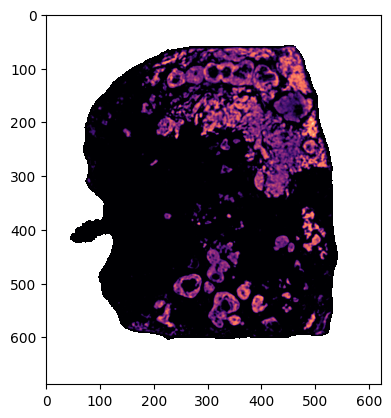

In [16]:
# Image.fromarray(img)

plt.imshow(x, cmap=cnt_color)    # cmap='turbo'
plt.gcf().set_dpi(100)
# plt.savefig(str(gn)+"expression_istar.pdf", format="pdf")
plt.show()

In [18]:
## another plot method
cnts = []
locs = []
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        color = x[i, j]
        if not np.isnan(color):
            cnts.append(color)
            locs.append([i, j])

locs = np.array(locs)
cnts = np.array(cnts)

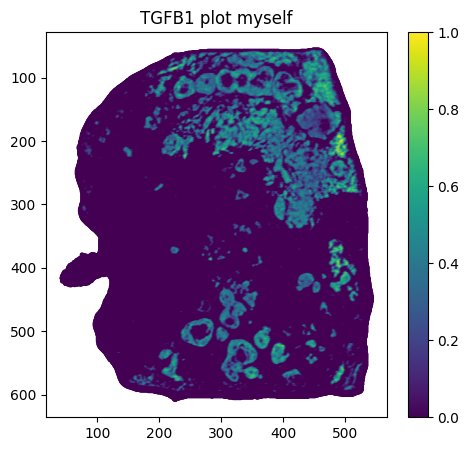

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5))
plot = ax.scatter(locs[:,1], locs[:,0], c=cnts, s=5)    
ax.set_title(str(gene_names[0]) + ' plot myself')
cbar = fig.colorbar(plot, ax=ax)
ax.invert_yaxis()
# plt.savefig("P1_pixel.pdf", format="pdf")
plt.gcf().set_dpi(100)
plt.show()

## Plot spot level expression

In [20]:
import os
os.chdir(f'{path}iSTAR/istar-master/data/{demo_data}')

In [21]:
def load_tsv(filename, index=True):
    if index:
        index_col = 0
    else:
        index_col = None
    df = pd.read_csv(filename, sep='\t', header=0, index_col=index_col)
    print(f'Dataframe loaded from {filename}')
    return df

def read_string(filename):
    return read_lines(filename)[0]


from PIL import Image
Image.MAX_IMAGE_PIXELS = None
def load_image(filename, verbose=True):
    img = Image.open(filename)
    img = np.array(img)
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[..., :3]  # remove alpha channel
    if verbose:
        print(f'Image loaded from {filename}')
    return img

In [22]:
factor = 16

infile_cnts = 'cnts.tsv'
infile_locs = 'locs.tsv'
infile_img = 'he.jpg'
infile_genes = 'gene-names.txt'
infile_radius = 'radius.txt'

# load data
cnts = load_tsv(infile_cnts)
locs = load_tsv(infile_locs)

Dataframe loaded from cnts.tsv
Dataframe loaded from locs.tsv


In [23]:
print(cnts.index)
print(locs.index)

Index(['AACACCTACTATCGAA-1', 'AACACGTGCATCGCAC-1', 'AACACTTGGCAAGGAA-1',
       'AACAGGAAGAGCATAG-1', 'AACAGGATTCATAGTT-1', 'AACAGGCCAACGATTA-1',
       'AACAGGTTATTGCACC-1', 'AACAGGTTCACCGAAG-1', 'AACAGTCAGGCTCCGC-1',
       'AACAGTCCACGCGGTG-1',
       ...
       'TGTTCGCAACCGCCAA-1', 'TGTTCGTGACCAGTAG-1', 'TGTTCTGCTCTGTCGT-1',
       'TGTTGCGTCCAAGATT-1', 'TGTTGGAACCTTCCGC-1', 'TGTTGGAACGAGGTCA-1',
       'TGTTGGAAGCTCGGTA-1', 'TGTTGGATGGACTTCT-1', 'TGTTGGCCAGACCTAC-1',
       'TGTTGGCCTACACGTG-1'],
      dtype='object', name='cellID', length=4992)
Index(['AACACCTACTATCGAA-1', 'AACACGTGCATCGCAC-1', 'AACACTTGGCAAGGAA-1',
       'AACAGGAAGAGCATAG-1', 'AACAGGATTCATAGTT-1', 'AACAGGCCAACGATTA-1',
       'AACAGGTTATTGCACC-1', 'AACAGGTTCACCGAAG-1', 'AACAGTCAGGCTCCGC-1',
       'AACAGTCCACGCGGTG-1',
       ...
       'TGTTCGCAACCGCCAA-1', 'TGTTCGTGACCAGTAG-1', 'TGTTCTGCTCTGTCGT-1',
       'TGTTGCGTCCAAGATT-1', 'TGTTGGAACCTTCCGC-1', 'TGTTGGAACGAGGTCA-1',
       'TGTTGGAAGCTCGGTA-1', 'TGTTGGA

In [24]:
## 检查 `cnts` 和 `locs` 数据是否具有相同的索引
## 通过比较它们的索引（`cnts.index` 和 `locs.index`）并确保它们相等来实现的
## 如果索引不相等，则 `assert` 语句将引发一个异常，指示数据之间存在不匹配。
assert (cnts.index == locs.index).all()
spot_radius = int(read_string(infile_radius))
img = load_image(infile_img)

Image loaded from he.jpg


In [25]:
if img.dtype == bool:
    img = img.astype(np.uint8) * 255
if img.ndim == 2:
    img = np.tile(img[..., np.newaxis], 3)

In [27]:
## select genes
gene_names = read_lines(infile_genes)
cnts = cnts[gene_names]
cnts

,TGFB1,TGFBR1,TGFBR2,TGFB2,TGFB3,ACVR1B,ACVR1C,ACVR1,BMP2,BMPR1A,...,FOXH1,GLUD1,MON1B,HMOX1,PLEKHM1,OBSL1,SLC41A2,CHIT1,CYP24A1,CLIC6
cellID,,,,,,,,,,,,,,,,,,,,,
AACACCTACTATCGAA-1,0,0,10,0,0,0,0,1,0,2,...,1,1,1,2,0,4,1,1,0,0
AACACGTGCATCGCAC-1,0,1,3,0,2,0,0,0,0,1,...,1,1,0,0,1,0,1,0,0,0
AACACTTGGCAAGGAA-1,0,1,2,2,6,1,0,1,1,2,...,0,3,2,3,0,0,1,0,0,0
AACAGGAAGAGCATAG-1,0,1,3,0,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AACAGGATTCATAGTT-1,1,0,3,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACGAGGTCA-1,1,1,10,0,4,0,0,1,0,0,...,0,1,0,2,0,0,1,0,0,0
TGTTGGAAGCTCGGTA-1,3,4,16,0,5,1,0,1,0,3,...,0,4,1,1,1,2,0,1,0,1
TGTTGGATGGACTTCT-1,0,3,7,0,4,1,0,1,0,3,...,0,15,4,6,1,7,2,0,10,1


In [29]:
## recale image
locs = locs.astype(float)
locs = np.stack([locs['y'], locs['x']], -1)
# print("locs:\n", locs)
locs /= factor
locs = locs.round().astype(int)
# print("locs:\n", locs)

from einops import reduce
img = reduce(
        img.astype(float), '(h1 h) (w1 w) c -> h1 w1 c', 'mean',
        h=factor, w=factor).astype(np.uint8)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

spot_radius:  6
spot_radius:  3


In [35]:
def get_disk_mask(radius, boundary_width=None):
    radius_ceil = np.ceil(radius).astype(int)
    locs = np.meshgrid(
            np.arange(-radius_ceil, radius_ceil+1),
            np.arange(-radius_ceil, radius_ceil+1),
            indexing='ij')
    locs = np.stack(locs, -1)
    distsq = (locs**2).sum(-1)
    isin = distsq <= radius**2
    if boundary_width is not None:
        isin *= distsq >= (radius-boundary_width)**2
    return isin

def save_image(img, filename):
    # mkdir(filename)
    Image.fromarray(img).save(filename)
    print(filename)

import matplotlib.pyplot as plt
def plot_spots(
        img, cnts, locs, radius, outfile, cmap='magma',
        weight=0.8, disk_mask=True, standardize_img=False):
    cnts = cnts.astype(np.float32)

    img = img.astype(np.float32)
    img /= 255.0

    if standardize_img:
        if np.isclose(0.0, np.nanstd(img, (0, 1))).all():
            img[:] = 1.0
        else:
            img -= np.nanmin(img)
            img /= np.nanmax(img) + 1e-12

    cnts -= np.nanmin(cnts)
    cnts /= np.nanmax(cnts) + 1e-12

    cmap = plt.get_cmap(cmap)
    if disk_mask:
        mask_patch = get_disk_mask(radius)
    else:
        mask_patch = np.ones((radius*2, radius*2)).astype(bool)
    indices_patch = np.stack(np.where(mask_patch), -1)
    indices_patch -= radius
    for ij, ct in zip(locs, cnts):
        color = np.array(cmap(ct)[:3])
        indices = indices_patch + ij
        img[indices[:, 0], indices[:, 1]] *= 1 - weight
        img[indices[:, 0], indices[:, 1]] += color * weight
    img = (img * 255).astype(np.uint8)
    save_image(img, outfile)     ## LLY
    # return img     ## LLY

def plot_spots_show(
        img, cnts, locs, radius, outfile, cmap='magma',
        weight=0.8, disk_mask=True, standardize_img=False):
    cnts = cnts.astype(np.float32)

    img = img.astype(np.float32)
    img /= 255.0

    if standardize_img:
        if np.isclose(0.0, np.nanstd(img, (0, 1))).all():
            img[:] = 1.0
        else:
            img -= np.nanmin(img)
            img /= np.nanmax(img) + 1e-12

    cnts -= np.nanmin(cnts)
    cnts /= np.nanmax(cnts) + 1e-12

    cmap = plt.get_cmap(cmap)
    if disk_mask:
        mask_patch = get_disk_mask(radius)
    else:
        mask_patch = np.ones((radius*2, radius*2)).astype(bool)
    indices_patch = np.stack(np.where(mask_patch), -1)
    indices_patch -= radius
    for ij, ct in zip(locs, cnts):
        color = np.array(cmap(ct)[:3])
        indices = indices_patch + ij
        img[indices[:, 0], indices[:, 1]] *= 1 - weight
        img[indices[:, 0], indices[:, 1]] += color * weight
    img = (img * 255).astype(np.uint8)
    # save_image(img, outfile)     ## LLY
    return img     ## LLY

ct shape: (4992,)
spot_radius:  2


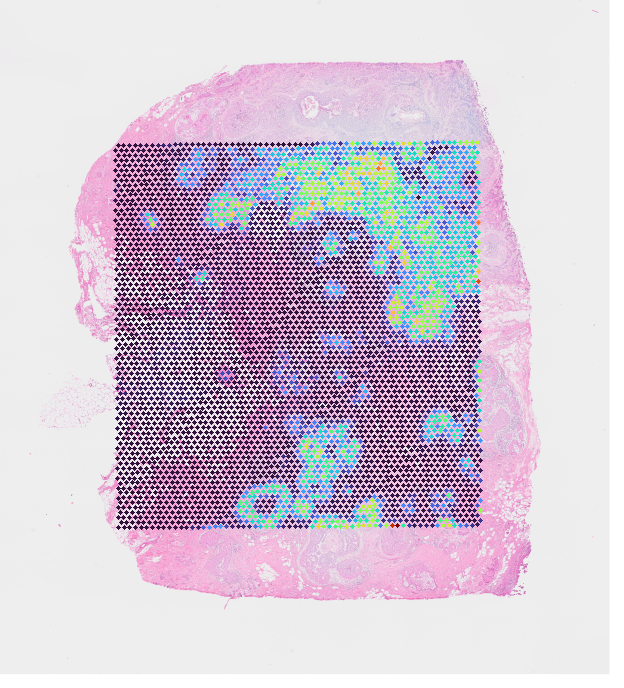

In [40]:
gene = 'ERBB2'
ct = np.array(cnts[str(gene)])
print("ct shape:", ct.shape)

results_path = 'Results/'
save_dir = os.path.join(f'{path}iSTAR/istar-master/data/{demo_data}', results_path)
os.makedirs(save_dir, exist_ok=True)  

## rescale spot
spot_radius = np.round(spot_radius / factor).astype(int)    # 100/16
## `plot_spots_show` 函数中，点（像素）的大小由变量 `radius` 控制
## define spot_radius by myself
spot_radius = 2
print("spot_radius: ", spot_radius)

radius=spot_radius
disk_mask=True
prefix = f'{path}iSTAR/istar-master/data/{demo_data}{results_path}'
outfile = str(prefix)+str(gene)+'.png'
image = plot_spots_show(
        img=img, cnts=ct, locs=locs, radius=radius,
        cmap='turbo', weight=1.0,
        disk_mask=disk_mask,
        outfile=outfile)

Image.fromarray(image)    ## LLY

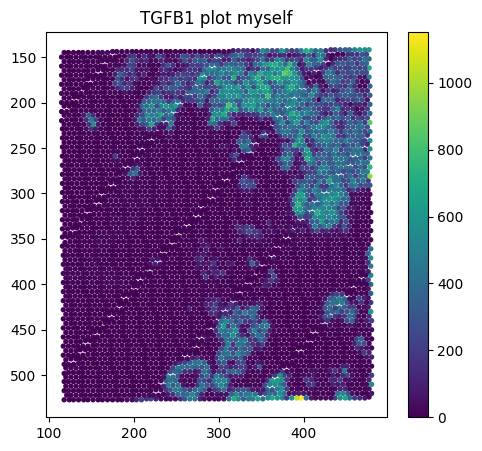

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5))
plot_spot = ax.scatter(locs[:,1], locs[:,0], c=ct, s=8)    
ax.set_title(str(gene_names[0]) + ' plot myself')
cbar = fig.colorbar(plot_spot, ax=ax)
ax.invert_yaxis()
# plt.savefig("P1_spot.pdf", format="pdf")
plt.gcf().set_dpi(100)
plt.show()

## Order the position and obtain the expression (matched spot)

In [ ]:
adata = sc.read_visium(f'{path}FineST/FineST_demo/BRCAhuman_data')
cellID = adata.obs_names.tolist()

In [19]:
import os
os.chdir(f'{path}iSTAR/istar-master/data/{demo_data}')

## adaress loc0, according to locs
factor = 16
locs_spot = load_tsv("locs.tsv")
locs_spot = locs_spot.astype(float)
locs_spot = np.stack([locs_spot['y'], locs_spot['x']], -1)
locs_spot /= factor
locs_spot = locs_spot.round().astype(int)

## Load gene expression
gene_names = read_lines('gene-names.txt')
cnts = load_pickle('cnts-super/'+str(gene_names[0])+'.pickle')
mask = load_image('mask-small.png') > 0
cnts[~mask] = np.nan
x = cnts.copy()

## another plot method
cnts_pixel = []
locs_pixel = []
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        color = x[i, j]
        if not np.isnan(color):
            cnts_pixel.append(color)
            locs_pixel.append([i, j])

locs_pixel = np.array(locs_pixel)
cnts_pixel = np.array(cnts_pixel)

from scipy.spatial import cKDTree
tree = cKDTree(locs_pixel)
_, closest_points_indices = tree.query(locs_spot, k=1)
print(len(closest_points_indices))
locs_order = locs_pixel[closest_points_indices]

Dataframe loaded from locs.tsv
Image loaded from mask-small.png
4992


In [20]:
## cycle all genes
import numpy as np
import pandas as pd
import os
os.chdir(f'{path}iSTAR/istar-master/data/{demo_data}')
gene_names = read_lines('gene-names.txt')
mask = load_image('mask-small.png') > 0

cnts_order_gene = []
for gn in gene_names:
    cnts = load_pickle('cnts-super/' + str(gn) + '.pickle')
    cnts[~mask] = np.nan
    x = cnts.copy()

    cnts_order = []
    for loc in locs_order:
        i, j = loc
        value = x[i, j]
        cnts_order.append(value)
    cnts_order = np.array(cnts_order)
    cnts_order_gene.append(cnts_order)

cnts_order_gene = np.column_stack(cnts_order_gene)
cnts_order_gene = pd.DataFrame(cnts_order_gene, columns=gene_names)

print(cnts_order_gene.shape)

Image loaded from mask-small.png
(4992, 957)


In [21]:
cnts_order_gene.insert(0, 'cellID', cellID)   
cnts_order_gene.head()

,cellID,TGFB1,TGFBR1,TGFBR2,TGFB2,TGFB3,ACVR1B,ACVR1C,ACVR1,BMP2,...,FOXH1,GLUD1,MON1B,HMOX1,PLEKHM1,OBSL1,SLC41A2,CHIT1,CYP24A1,CLIC6
0,AACACCTACTATCGAA-1,0.000818,0.002497,0.038312,0.000611,0.009973,0.001937,0.000242,0.008127,0.000733,...,0.000203,0.002530,0.001549,0.004602,0.001650,0.011677,0.004193,0.009613,0.001771,0.000234
1,AACACGTGCATCGCAC-1,0.006404,0.006927,0.052751,0.000578,0.021452,0.002409,0.000246,0.004879,0.001220,...,0.000210,0.002571,0.003542,0.004647,0.002430,0.006376,0.002569,0.010500,0.001878,0.000245
2,AACACTTGGCAAGGAA-1,0.017627,0.013364,0.062417,0.004238,0.042335,0.000698,0.000658,0.009039,0.000314,...,0.000205,0.002463,0.001555,0.010897,0.000503,0.002900,0.003979,0.009000,0.001506,0.000508
3,AACAGGAAGAGCATAG-1,0.000793,0.001545,0.003422,0.000565,0.002518,0.000715,0.000238,0.001230,0.000321,...,0.000196,0.002346,0.001471,0.004621,0.000410,0.001301,0.001330,0.010482,0.001642,0.000230
4,AACAGGATTCATAGTT-1,0.001531,0.004204,0.009637,0.000966,0.015066,0.000744,0.000240,0.002444,0.000322,...,0.000201,0.002409,0.001508,0.004563,0.000817,0.004545,0.001366,0.010569,0.001715,0.000240


In [22]:
## save the expression profile of istar
results_path = 'Results/'
save_dir = os.path.join(f'{path}iSTAR/istar-master/data/{demo_data}', results_path)
os.makedirs(save_dir, exist_ok=True)  
# cnts_order_gene.to_csv(f'{results_path}istar_predict_expression.tsv', sep='\t', index=False)

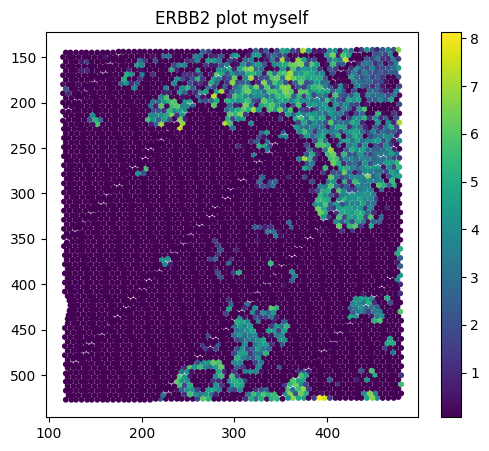

In [25]:
## plot in spot level
gene = 'ERBB2'
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_spot = ax.scatter(locs_order[:,1], locs_order[:,0], c=cnts_order_gene[str(gene)], s=10)    
ax.set_title(str(gene) + ' plot myself')
cbar = fig.colorbar(plot_spot, ax=ax)
ax.invert_yaxis()
# plt.savefig("P1_spot.pdf", format="pdf")
plt.gcf().set_dpi(100)
plt.show()

## get LRgene-names.txt 

In [75]:
# Load LR gene
LRgene = pd.read_csv(str(path)+'iSTAR/human_breast_Xenium/LRgene_CellChatDB_baseline.csv')

## NPC1 selected gene
patientxy = 'BRCA_human'
import scanpy
BRCA_pixel = scanpy.read_h5ad(str(path)+'NPC/Data/stdata/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_all.h5ad')
print(BRCA_pixel)


feature_names = np.array(BRCA_pixel.var.index.astype("str"))
print("feature_names shape: ", len(feature_names)) 

lr_gene_list = LRgene['LR gene'].tolist()
# available_genes = pd.DataFrame([gene for gene in lr_gene_list if gene in matrix1.columns])
available_genes = pd.DataFrame([gene for gene in lr_gene_list if gene in feature_names])
print(available_genes.shape)

# available_genes.to_csv("LRgene-names.txt", sep='\t', index=False, header=False)

In [73]:
################################
# Update 2025.06.24
################################
# demo_data = 'BRCAhuman_data/'   
# save_data = 'SaveData_HVLR/'
# import scanpy as sc
# BRCA_pixel = sc.read_h5ad(f'{path}FineST/FineST_demo/{demo_data}{save_data}adata_imput_all_subspot.h5ad')
# print(BRCA_pixel)
# feature_names = pd.DataFrame(np.array(BRCA_pixel.var.index.astype("str")))
# print("feature_names shape: ", len(feature_names)) 
# feature_names.to_csv(f'{path}/iSTAR/istar-master/data/BRCA_revised/gene-names.txt', sep='\t', index=False, header=False)

## Compare with original data

In [41]:
## Load gene expression and spatial location
import os
demo_data = 'BRCA_revised/'   
os.chdir(f'{path}iSTAR/istar-master/data/{demo_data}')

pixel_adata = load_tsv(f'{results_path}istar_predict_expression.tsv', )
print(pixel_adata.shape)
feature_names = np.array(pixel_adata.columns.astype("str"))
visium_adata = load_tsv('cnts.tsv')[feature_names]
print(visium_adata.shape)

Dataframe loaded from Results/istar_predict_expression.tsv
(4992, 957)
Dataframe loaded from cnts.tsv
(4992, 957)


In [51]:
## Data setup
## Collating both interpolated Visium spots and actual Visium spots
## The Xenium and Visium gene sets differ; here we are filtering the two data frames to
## ensure they share the exact same genes. In addition, we can only interpolate Visium spot counts for
## which we have Xenium data. We remove all spots which do not overlap between the two modalities.

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
def plot_gene_correlation(
    visium_adata, pixel_adata,  gene, 
    xlabel="Visium transcript count", ylabel="iStar transcript count"
):

    corr, p_value = pearsonr(visium_adata[gene], pixel_adata[gene])
    print("corr, p_value: ", corr, p_value)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(visium_adata[gene], pixel_adata[gene], s=5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.annotate(f"Pearson's R: {corr:.2f}", xy=(0.55, 0.05), xycoords="axes fraction", fontsize=12)
    plt.show()
    
    return corr, p_value

corr, p_value:  0.8990111845992227 0.0


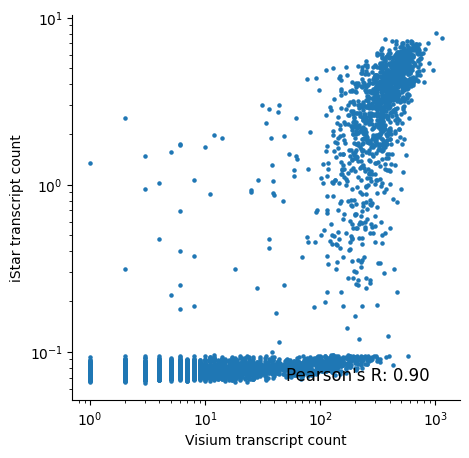

In [52]:
corr, p_value = plot_gene_correlation(visium_adata, pixel_adata, gene="ERBB2")

In [118]:
!pwd

/ssd/users/lingyu/Python/iSTAR/istar-master/data/BRCA


In [53]:
## RMSE
def rmse(y_pred, y_mean_pred):
    # TODO: try l1 loss
    mse = ((y_mean_pred - y_pred)**2).mean()
    loss = mse**0.5
    return loss


rmse_istar = rmse(visium_adata, pixel_adata)
print(rmse_istar)
# rmse_istar.to_csv("rmse_iStar.csv")    # , index=False, header=False

TGFB1      1.537778
TGFBR1     2.856642
TGFBR2     7.018730
TGFB2      0.665569
TGFB3      3.509756
             ...   
OBSL1      2.427695
SLC41A2    1.519788
CHIT1      8.292872
CYP24A1    3.665540
CLIC6      0.267567
Length: 957, dtype: float64


In [55]:
## JSD results
import numpy as np
from scipy.spatial.distance import jensenshannon

def compute_jsd_between_matrices(matrix1, matrix2, axis=0):
    # 计算每一行或列的概率分布
    probabilities1 = matrix1 / np.sum(matrix1, axis=axis, keepdims=True)
    probabilities2 = matrix2 / np.sum(matrix2, axis=axis, keepdims=True)

    # 计算Jensen-Shannon Divergence
    jsd = np.zeros(matrix1.shape[1 - axis])
    for i in range(matrix1.shape[1 - axis]):
        if axis == 0:
            p = probabilities1[:, i]
            q = probabilities2[:, i]
        else:
            p = probabilities1[i, :]
            q = probabilities2[i, :]
        jsd[i] = jensenshannon(p, q)
    return jsd

# 首先将dataframe转换为numpy数组
shared_visium_np = visium_adata.to_numpy()
shared_xenium_np = pixel_adata.to_numpy()

# 计算pixel_adata和visium_adata关于sample的JSD
FineST_spot_JSD_subspot_np = compute_jsd_between_matrices(shared_xenium_np, shared_visium_np, axis=1)
FineST_spot_JSD_subspot = pd.DataFrame(FineST_spot_JSD_subspot_np, columns=['iStar_JSD'])

# 计算pixel_adata和visium_adata关于feature的JSD
FineST_gene_JSD_subspot_np = compute_jsd_between_matrices(shared_xenium_np, shared_visium_np, axis=0)
FineST_gene_JSD_subspot = pd.DataFrame(FineST_gene_JSD_subspot_np, columns=['iStar_JSD'])

print(FineST_spot_JSD_subspot.head())
print(FineST_spot_JSD_subspot['iStar_JSD'].mean())
print(FineST_gene_JSD_subspot.head())
print(FineST_gene_JSD_subspot['iStar_JSD'].mean())

   iStar_JSD
0   0.341650
1   0.330715
2   0.296581
3   0.471504
4   0.337379
0.3708992284554627
   iStar_JSD
0   0.405381
1   0.302953
2   0.243475
3   0.587804
4   0.296378
0.5773440259834512


In [57]:
## save JSD
FineST_spot_JSD_subspot.to_csv(f"{results_path}JSDspot_istar.csv")   
FineST_gene_JSD_subspot.to_csv(f"{results_path}JSDgene_istar.csv")    

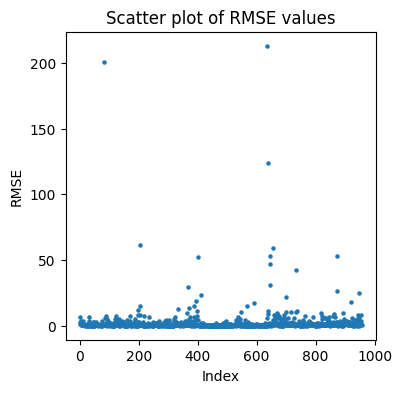

213.1155329087496
636


'COL1A1'

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rmse_scatter(mat1, mat2, figsize=(4, 4), title="Scatter plot of RMSE values"):
    arr1 = mat1.to_numpy() if hasattr(mat1, "to_numpy") else np.asarray(mat1)
    arr2 = mat2.to_numpy() if hasattr(mat2, "to_numpy") else np.asarray(mat2)

    rmse_values = np.sqrt(np.mean((arr1 - arr2) ** 2, axis=0))

    plt.figure(figsize=figsize)
    plt.scatter(np.arange(len(rmse_values)), rmse_values, s=5)
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("RMSE")
    plt.show()
    return rmse_values

rmse_values = plot_rmse_scatter(visium_adata, pixel_adata)
print(np.max(rmse_values))
print(np.argmax(rmse_values))
feature_names[np.argmax(rmse_values)]

corr, p_value:  0.789156068449061 0.0


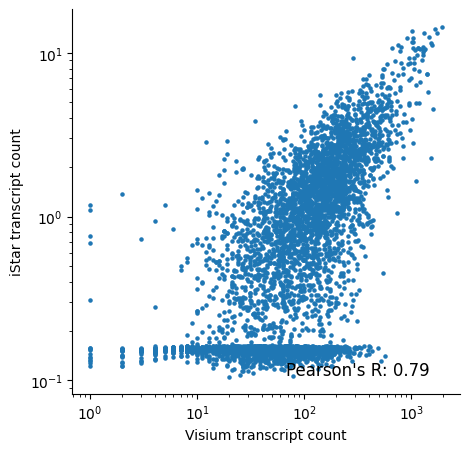

In [60]:
corr, p_value = plot_gene_correlation(visium_adata, pixel_adata, gene=feature_names[np.argmax(rmse_values)])

Pearson correlations:  0.40434637930192036


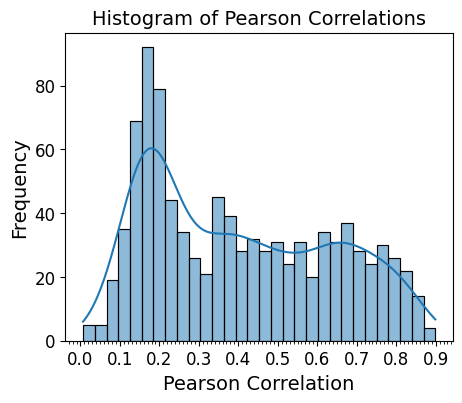

In [65]:
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MultipleLocator   # adjust axies
def cor_hist(adata, adata_df_infer, max_step=0.1, min_step=0.01,
             fig_size=(5, 4), trans=False, format='svg', save_path=None, label_fontsize=14, tick_fontsize=12):
    ## Check if input is AnnData or DataFrame and handle accordingly
    if isinstance(adata, pd.DataFrame):
        pearson_correlations = [stats.pearsonr(adata[col].values, adata_df_infer[col].values)[0] for col in adata.columns]
    else:
        pearson_correlations = [stats.pearsonr(adata.to_df()[col].values, adata_df_infer[col].values)[0] for col in adata.to_df().columns]
    print('Pearson correlations: ', np.mean(pearson_correlations))

    fig = plt.figure(figsize=fig_size)
    ax = sns.histplot(data=pearson_correlations, bins=30, kde=True)
    ax.xaxis.set_major_locator(MultipleLocator(max_step))
    ax.xaxis.set_minor_locator(MultipleLocator(min_step))
    plt.title("Histogram of Pearson Correlations", fontsize=label_fontsize)
    plt.xlabel("Pearson Correlation", fontsize=label_fontsize)
    plt.ylabel("Frequency", fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

    if save_path is not None:
        plt.savefig(save_path, transparent=trans, format=format, dpi=300, bbox_inches='tight')
    plt.show()


## Pearson correlations
cor_hist(visium_adata, pixel_adata, 
                 fig_size=(5, 4), trans=False, format='svg', 
                 save_path=f'{results_path}Hist_infer_cor_count.svg')

In [66]:
from scipy.stats import pearsonr

def compute_pearsonr(df1, df2, axis=0, label_name=None):
    if axis == 0:
        labels = df1.columns
        if label_name is None:
            label_name = 'Gene'
        results = [pearsonr(df1[col], df2[col]) for col in labels]
    else:
        labels = df1.index
        if label_name is None:
            label_name = 'Sample'
        results = [pearsonr(df1.loc[idx], df2.loc[idx]) for idx in labels]
    corr, pval = zip(*results)
    return pd.DataFrame({label_name: labels, 'correlation_coefficient': corr, 'p_value': pval})

columns_result_df = compute_pearsonr(visium_adata, pixel_adata, axis=0)
rows_result_df    = compute_pearsonr(visium_adata, pixel_adata, axis=1)
print("columns_result_df: \n", columns_result_df)
print("rows_result_df: \n", rows_result_df)

columns_result_df: 
         Gene  correlation_coefficient        p_value
0      TGFB1                 0.588202   0.000000e+00
1     TGFBR1                 0.700630   0.000000e+00
2     TGFBR2                 0.704799   0.000000e+00
3      TGFB2                 0.467095  4.872024e-269
4      TGFB3                 0.712105   0.000000e+00
..       ...                      ...            ...
952    OBSL1                 0.676631   0.000000e+00
953  SLC41A2                 0.571032   0.000000e+00
954    CHIT1                 0.006446   6.488707e-01
955  CYP24A1                 0.858766   0.000000e+00
956    CLIC6                 0.203217   1.108555e-47

[957 rows x 3 columns]
rows_result_df: 
                   Sample  correlation_coefficient        p_value
0     AACACCTACTATCGAA-1                 0.961646   0.000000e+00
1     AACACGTGCATCGCAC-1                 0.972372   0.000000e+00
2     AACACTTGGCAAGGAA-1                 0.966091   0.000000e+00
3     AACAGGAAGAGCATAG-1                 

In [68]:
## save correlation
columns_result_df.to_csv(f'{results_path}cor_iStar_Gene.csv')    
rows_result_df.to_csv(f'{results_path}cor_iStar_Sample.csv')  